# AE on CIFAR10 dataset
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

from sklearn.preprocessing import Normalizer, MinMaxScaler, minmax_scale
from sklearn.pipeline import Pipeline

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## import data
- import
- normalize

In [2]:
from tensorflow.keras.datasets import cifar10
(X_train, _), (X_test, _) = cifar10.load_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

In [3]:
X_train.shape

(50000, 32, 32, 3)

## build AE

In [4]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as kb
from tensorflow.keras import regularizers

encoder

In [5]:
input_img = Input(shape=(32,32,3))
regularizer = regularizers.l1(10e-5)
# model: encoder
encoded = Conv2D(64, (3, 3), activation='relu', 
                                padding='same')(input_img)
#encoded = Conv2D(64, (3, 3), activation='relu', 
#                                padding='same')(encoded)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)
encoded = Conv2D(32, (3, 3), activation='relu', 
                                padding='same')(encoded)
#encoded = Conv2D(32, (3, 3), activation='relu', 
#                                padding='same')(encoded)                                
encoded = MaxPooling2D((2, 2), padding='same')(encoded)
encoded = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)

input_encoded_before_flatten = kb.int_shape(encoded)
encoded = Flatten()(encoded)
encoder = Model(input_img, encoded)

input_encoded = Input(shape=kb.int_shape(encoded)[1:])
encoder.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 8)           2312      
_________________________________________________________________
flatten (Flatten)            (None, 512)               0     

decoder

In [6]:
# model: decoder
decoded = Reshape(input_encoded_before_flatten[1:])(input_encoded)
decoded = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
#decoded = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
decoded = Conv2D(64, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
#decoded = Conv2D(64, (3, 3), activation='relu', padding='same')(decoded)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoded)
decoder = Model(input_encoded, decoded)

decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          2336      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 3)         1731

autoencoder

In [7]:
# model: autoencoder
encoded = encoder(input_img)
decoded = decoder(encoded)
autoencoder = Model(input_img, decoded)

optimizer = Adam(learning_rate=0.002)
loss = tf.keras.losses.BinaryCrossentropy();

autoencoder.compile(optimizer=optimizer, loss=loss)

autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
model (Functional)           (None, 512)               22568     
_________________________________________________________________
model_1 (Functional)         (None, 32, 32, 3)         22563     
Total params: 45,131
Trainable params: 45,131
Non-trainable params: 0
_________________________________________________________________


## train AE

In [8]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=0.0005)
ckpt_filepath = 'model/checkpoint/'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpt_filepath,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True)
autoencoder.fit(X_train, X_train,
                epochs=25,
                batch_size=128,
                validation_data=(X_test, X_test),
                callbacks=[early_stopping,
                    checkpoint], # stop the training when no improvements are made
                verbose=1)

Epoch 1/25
391/391 [==============================] - 9s 16ms/step - loss: 0.5977 - val_loss: 0.5656
Epoch 2/25
391/391 [==============================] - 5s 14ms/step - loss: 0.5635 - val_loss: 0.5619
Epoch 3/25
391/391 [==============================] - 6s 14ms/step - loss: 0.5609 - val_loss: 0.5621
Epoch 4/25
391/391 [==============================] - 6s 14ms/step - loss: 0.5597 - val_loss: 0.5606
Epoch 5/25
391/391 [==============================] - 5s 14ms/step - loss: 0.5584 - val_loss: 0.5585
Epoch 6/25
391/391 [==============================] - 6s 14ms/step - loss: 0.5582 - val_loss: 0.5582
Epoch 7/25
391/391 [==============================] - 6s 14ms/step - loss: 0.5578 - val_loss: 0.5580
Epoch 8/25
391/391 [==============================] - 6s 14ms/step - loss: 0.5573 - val_loss: 0.5578
Epoch 9/25
391/391 [==============================] - 6s 15ms/step - loss: 0.5571 - val_loss: 0.5572
Epoch 10/25
391/391 [==============================] - 6s 16ms/step - loss: 0.5563 - val_lo

In [9]:
# save model
save_filepath = '/model/last'
autoencoder.save(
    filepath=save_filepath,
    overwrite=True,
    include_optimizer=True,
)
# load model
loaded_model = tf.keras.models.load_model('model/last')

INFO:tensorflow:Assets written to: /model/last\assets


## show results

In [10]:
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

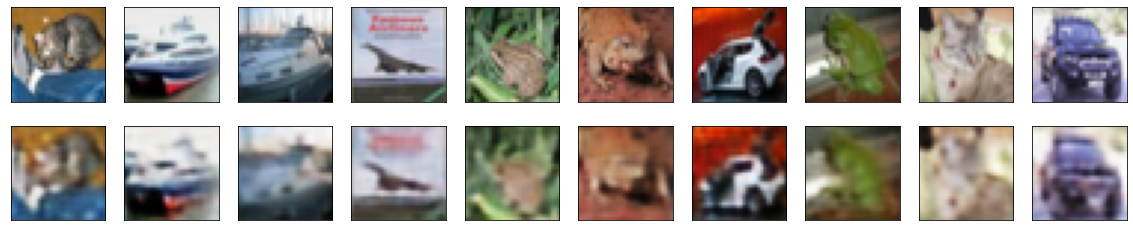

In [11]:
import matplotlib.pyplot as plt

n = 10  # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    #plt.imshow(X_test_normalized[i].reshape(28, 28))
    plt.imshow(X_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## combinging labels/categories

tbd